#  [Sec1] forward pretrianed-vggface19 model
## if mem less than 20GB directly go sec2
## read pretrained vgg face model

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sess = tf.InteractiveSession()
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()

graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [3]:
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3])
x_tf_1=tf.image.resize_images(x_tf,224,224)
y_tf = tf.placeholder(tf.int32, shape=[None,])
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded from disk"

graph = tf.get_default_graph()

graph loaded from disk


In [4]:
train_writer = tf.train.SummaryWriter('/tmp/loser3/train',sess.graph)

In [5]:
sess.graph.get_operations()[88].values()

(<tf.Tensor 'import/pool5:0' shape=(?, 7, 7, 512) dtype=float32>,)

In [6]:
#this will get all operation in graph
sess.graph.get_operations()
#we can get specific operation by
graph.get_tensor_by_name("import/Relu_1:0")

<tf.Tensor 'import/Relu_1:0' shape=(?, 4096) dtype=float32>

In [7]:
#what we want is the out come from fc_7
feature_net=graph.get_tensor_by_name("import/pool5:0")


In [8]:
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [9]:
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]

In [10]:
trial = sess.run([x_tf_1], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]

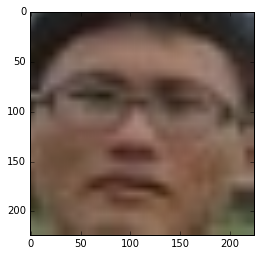

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(trial[3].astype('uint8'))

# forward pass all pictures

In [12]:
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]
feature_x2 = sess.run([feature_net], feed_dict={x_tf:frames[100:200], y_tf: y_train[100:200]})[0]
feature_x3 = sess.run([feature_net], feed_dict={x_tf:frames[200:300], y_tf: y_train[200:300]})[0]
feature_x4 = sess.run([feature_net], feed_dict={x_tf:frames[300:400], y_tf: y_train[300:400]})[0]
feature_x5 = sess.run([feature_net], feed_dict={x_tf:frames[400:500], y_tf: y_train[400:500]})[0]
feature_x6 = sess.run([feature_net], feed_dict={x_tf:frames[500:600], y_tf: y_train[500:600]})[0]
feature_x7 = sess.run([feature_net], feed_dict={x_tf:frames[600:700], y_tf: y_train[600:700]})[0]
feature_x8 = sess.run([feature_net], feed_dict={x_tf:frames[700:800], y_tf: y_train[700:800]})[0]
feature_x9 = sess.run([feature_net], feed_dict={x_tf:frames[800:900], y_tf: y_train[800:900]})[0]
feature_x10 = sess.run([feature_net], feed_dict={x_tf:frames[900:], y_tf: y_train[900:]})[0]

In [13]:
feature_x=(np.concatenate((feature_x1, feature_x2, feature_x3,
                    feature_x4, feature_x5, feature_x6,
                    feature_x7, feature_x8, feature_x9,
                    feature_x10), axis=0))
print feature_x.shape

(963, 7, 7, 512)


In [14]:
np.save("/home/stream/whimh2.0/finetune",feature_x)

In [15]:
from sklearn.preprocessing import normalize
#norm2 = normalize(feature_x, axis=1)
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 770 images in training set
there are 193 images in testing set


In [16]:
tf.reset_default_graph()
sess.close()

#  [Sec2] retrain WHIMH
# now train softmax model with (?,7,7,512) features 

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [18]:
feature_x=np.load("finetune.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [19]:
#from sklearn.preprocessing import normalize
#norm2 = normalize(feature_x, axis=1)
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 770 images in training set
there are 193 images in testing set


In [20]:
sess = tf.InteractiveSession()

In [21]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)

In [22]:
x_tfed = tf.placeholder(tf.float32, shape=[None,7,7,512])
y_tf = tf.placeholder(tf.int32, shape=[None,])

In [23]:
with tf.name_scope('finetune_layer'):
    #calculate_entropy
    h_pool3_flat = tf.reshape(x_tfed, [-1, 7*7*512])
    W_whimh_fc1 = weight_variable([7*7*512, 1024])
    b_whimh_fc1 = bias_variable([1024])
    h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
    tf.histogram_summary('fc_1/weights', W_whimh_fc1)
with tf.name_scope('finetune_layer'):
    #calculate_entropy
    W_whimh_fc2 = weight_variable([1024, 3])
    b_whimh_fc2 = bias_variable([3])
    y_conv=tf.nn.softmax(tf.matmul(h_fc1, W_whimh_fc2) + b_whimh_fc2) 
    tf.histogram_summary('fc_2/weights', W_whimh_fc2)

In [24]:
y_tf_2=tf.one_hot(y_tf,3)

with tf.name_scope('loss_calulate'):
    #calculate_entropy
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))

In [25]:
with tf.name_scope('regular'):    
    regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                    (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                   )
        
with tf.name_scope('loss'):  
    loss=cross_entropy+1e-3*regularizers

In [26]:
with tf.name_scope('slover'):
    train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)
with tf.name_scope('measure'):
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_tf_2,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #MHaccuracy
    idxsMH = tf.where(tf.equal(tf.argmax(y_tf_2,1), 0))
    correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_conv,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
    accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
    #NMaccuracy
    idxsNM = tf.where(tf.equal(tf.argmax(y_tf_2,1), 1))
    correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_conv,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
    accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
    #NHaccuracy
    idxsNH = tf.where(tf.equal(tf.argmax(y_tf_2,1), 2))
    correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_conv,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
    accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))
    
tf.scalar_summary('accuracy', accuracy)
tf.scalar_summary('accuracyMH', accuracyMH)
tf.scalar_summary('accuracyNM', accuracyNM)
tf.scalar_summary('accuracyNH', accuracyNH)
#this variable means records all records
merged = tf.merge_all_summaries()
sess.run(tf.initialize_all_variables())

In [27]:
train_writer = tf.train.SummaryWriter('/tmp/loser3/train',sess.graph)
test_writer = tf.train.SummaryWriter('/tmp/loser3/test',sess.graph)

In [28]:
sess.run(tf.initialize_all_variables())

In [29]:
k=0
for i in range(500):
  arr=np.arange(len(data['X_train']))
  np.random.shuffle(arr)
  idx = arr[:60]
  train_step.run(feed_dict={x_tfed:data['X_train'][idx], y_tf: data['y_train'][idx]})
  if i%10==0:
    ############training acc###########
    #train_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
    summary, train_accuracy = sess.run([merged, accuracy], feed_dict={   
            x_tfed:data['X_train'], y_tf: data['y_train']})
    train_writer.add_summary(summary, i)
    ############testing acc#########
    #testing_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_val'], y_tf: data['y_val'], keep_prob: 1.0})
    
    summary, testing_accuracy = sess.run([merged, accuracy], feed_dict={   
            x_tfed:data['X_val'], y_tf: data['y_val']})
    test_writer.add_summary(summary, i)
    print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    
#overall
print("test accuracy %g"%accuracy.eval(feed_dict={
    x_tfed:data['X_val'], y_tf: data['y_val']}))

step 0, training accuracy 0.575325, testing acc 0.57513
step 10, training accuracy 0.958442, testing acc 0.963731
step 20, training accuracy 0.97013, testing acc 0.963731
step 30, training accuracy 0.987013, testing acc 0.989637
step 40, training accuracy 0.992208, testing acc 0.979275
step 50, training accuracy 0.996104, testing acc 0.974093
step 60, training accuracy 0.997403, testing acc 0.979275
step 70, training accuracy 0.998701, testing acc 0.979275
step 80, training accuracy 0.998701, testing acc 0.974093
step 90, training accuracy 0.998701, testing acc 0.979275
step 100, training accuracy 1, testing acc 0.979275
step 110, training accuracy 1, testing acc 0.974093
step 120, training accuracy 1, testing acc 0.974093
step 130, training accuracy 1, testing acc 0.974093
step 140, training accuracy 1, testing acc 0.974093
step 150, training accuracy 1, testing acc 0.974093
step 160, training accuracy 1, testing acc 0.974093
step 170, training accuracy 1, testing acc 0.974093
step 18

In [30]:
#proto
tf.train.write_graph(sess.graph_def, "/home/stream/whimh2", "pretensorWhimh.pb", False) 

In [31]:
#save weights
saver=tf.train.Saver(tf.all_variables())
saver.save(sess,"PretensorWhimh.ckpt")

'PretensorWhimh.ckpt'

In [32]:
tf.reset_default_graph()
sess.close()

# [sec3] restore session(load model)

In [33]:
sess = tf.InteractiveSession()
x_tfed = tf.placeholder(tf.float32, shape=[None,7,7,512])
y_tf = tf.placeholder(tf.int32, shape=[None,])
with tf.name_scope('finetune_layer'):
    #calculate_entropy
    h_pool3_flat = tf.reshape(x_tfed, [-1, 7*7*512])
    W_whimh_fc1 = weight_variable([7*7*512, 1024])
    b_whimh_fc1 = bias_variable([1024])
    h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
    tf.histogram_summary('fc_1/weights', W_whimh_fc1)
with tf.name_scope('finetune_layer'):
    #calculate_entropy
    W_whimh_fc2 = weight_variable([1024, 3])
    b_whimh_fc2 = bias_variable([3])
    y_conv=tf.nn.softmax(tf.matmul(h_fc1, W_whimh_fc2) + b_whimh_fc2) 
    tf.histogram_summary('fc_2/weights', W_whimh_fc2)
    y_tf_2=tf.one_hot(y_tf,3)
with tf.name_scope('loss_calulate'):
    #calculate_entropy
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
with tf.name_scope('regular'):    
    regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                    (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                   )
        
with tf.name_scope('loss'):  
    loss=cross_entropy+1e-3*regularizers

with tf.name_scope('slover'):
    train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)
with tf.name_scope('measure'):
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_tf_2,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    #MHaccuracy
    idxsMH = tf.where(tf.equal(tf.argmax(y_tf_2,1), 0))
    correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_conv,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
    accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
    #NMaccuracy
    idxsNM = tf.where(tf.equal(tf.argmax(y_tf_2,1), 1))
    correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_conv,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
    accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
    #NHaccuracy
    idxsNH = tf.where(tf.equal(tf.argmax(y_tf_2,1), 2))
    correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_conv,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
    accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))
    
tf.scalar_summary('accuracy', accuracy)
tf.scalar_summary('accuracyMH', accuracyMH)
tf.scalar_summary('accuracyNM', accuracyNM)
tf.scalar_summary('accuracyNH', accuracyNH)
#this variable means records all records
merged = tf.merge_all_summaries()
sess.run(tf.initialize_all_variables())

In [34]:
saver=tf.train.Saver()
saver.restore(sess, "PretensorWhimh.ckpt") 

In [35]:
print("test accuracy %g"%accuracy.eval(feed_dict={
    x_tfed:data['X_val'], y_tf: data['y_val']}))

test accuracy 0.974093


In [36]:
tf.argmax(y_conv,1).eval(feed_dict={x_tfed:data['X_val'], y_tf: data['y_val']})

array([1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1,
       1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 0, 1, 2, 1])